In [3]:
# Library

import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import japanize_matplotlib
%matplotlib inline
import shap
import lightgbm as lgb
import optuna

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix, f1_score, ConfusionMatrixDisplay, classification_report
from sklearn.preprocessing import StandardScaler
from lightgbm import LGBMClassifier, early_stopping
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

# Data

In [16]:
df_train = pd.read_csv('train.tsv', sep='\t')
df_test = pd.read_csv('test.tsv', sep='\t')

In [22]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4062 entries, 0 to 4061
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   id                        4062 non-null   int64 
 1   Y                         4062 non-null   object
 2   cap-shape                 4062 non-null   object
 3   cap-surface               4062 non-null   object
 4   cap-color                 4062 non-null   object
 5   bruises                   4062 non-null   object
 6   odor                      4062 non-null   object
 7   gill-attachment           4062 non-null   object
 8   gill-spacing              4062 non-null   object
 9   gill-size                 4062 non-null   object
 10  gill-color                4062 non-null   object
 11  stalk-shape               4062 non-null   object
 12  stalk-root                4062 non-null   object
 13  stalk-surface-above-ring  4062 non-null   object
 14  stalk-surface-below-ring

In [24]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4062 entries, 0 to 4061
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   id                        4062 non-null   int64 
 1   cap-shape                 4062 non-null   object
 2   cap-surface               4062 non-null   object
 3   cap-color                 4062 non-null   object
 4   bruises                   4062 non-null   object
 5   odor                      4062 non-null   object
 6   gill-attachment           4062 non-null   object
 7   gill-spacing              4062 non-null   object
 8   gill-size                 4062 non-null   object
 9   gill-color                4062 non-null   object
 10  stalk-shape               4062 non-null   object
 11  stalk-root                4062 non-null   object
 12  stalk-surface-above-ring  4062 non-null   object
 13  stalk-surface-below-ring  4062 non-null   object
 14  stalk-color-above-ring  

In [26]:
df_train.head()

,id,Y,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,0,p,f,y,n,f,f,f,c,n,...,k,w,w,p,w,o,e,w,v,d
1,2,p,f,y,y,f,f,f,c,b,...,k,b,p,p,w,o,l,h,y,g
2,3,e,b,y,w,t,l,f,c,b,...,s,w,w,p,w,o,p,k,n,m
3,5,p,x,s,b,t,f,f,c,b,...,s,w,w,p,w,o,p,h,v,u
4,7,p,x,s,w,t,f,f,c,b,...,f,w,w,p,w,o,p,h,v,g


# EDA

<Axes: xlabel='Y'>

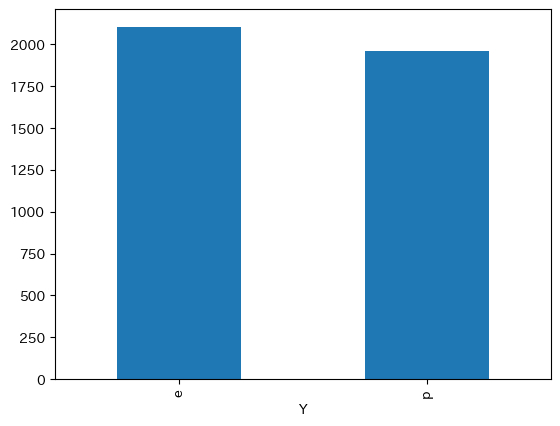

In [37]:
df_train['Y'].value_counts().plot(kind='bar')

# Model

In [50]:
# Features
X = df_train.drop(['id', 'Y'], axis=1)
y = df_train['Y']
y = y.map({'e': '0', 'p': '1'})

# One-hot-encoding
X = pd.get_dummies(X, )

# Split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [52]:
# Model
model_rf = RandomForestClassifier(n_estimators=100, random_state=42)
model_rf.fit(X_train, y_train)

# Pred
y_pred = model_rf.predict(X_valid)
print(f'Accuracy:', accuracy_score(y_pred, y_valid) )

Accuracy: 1.0


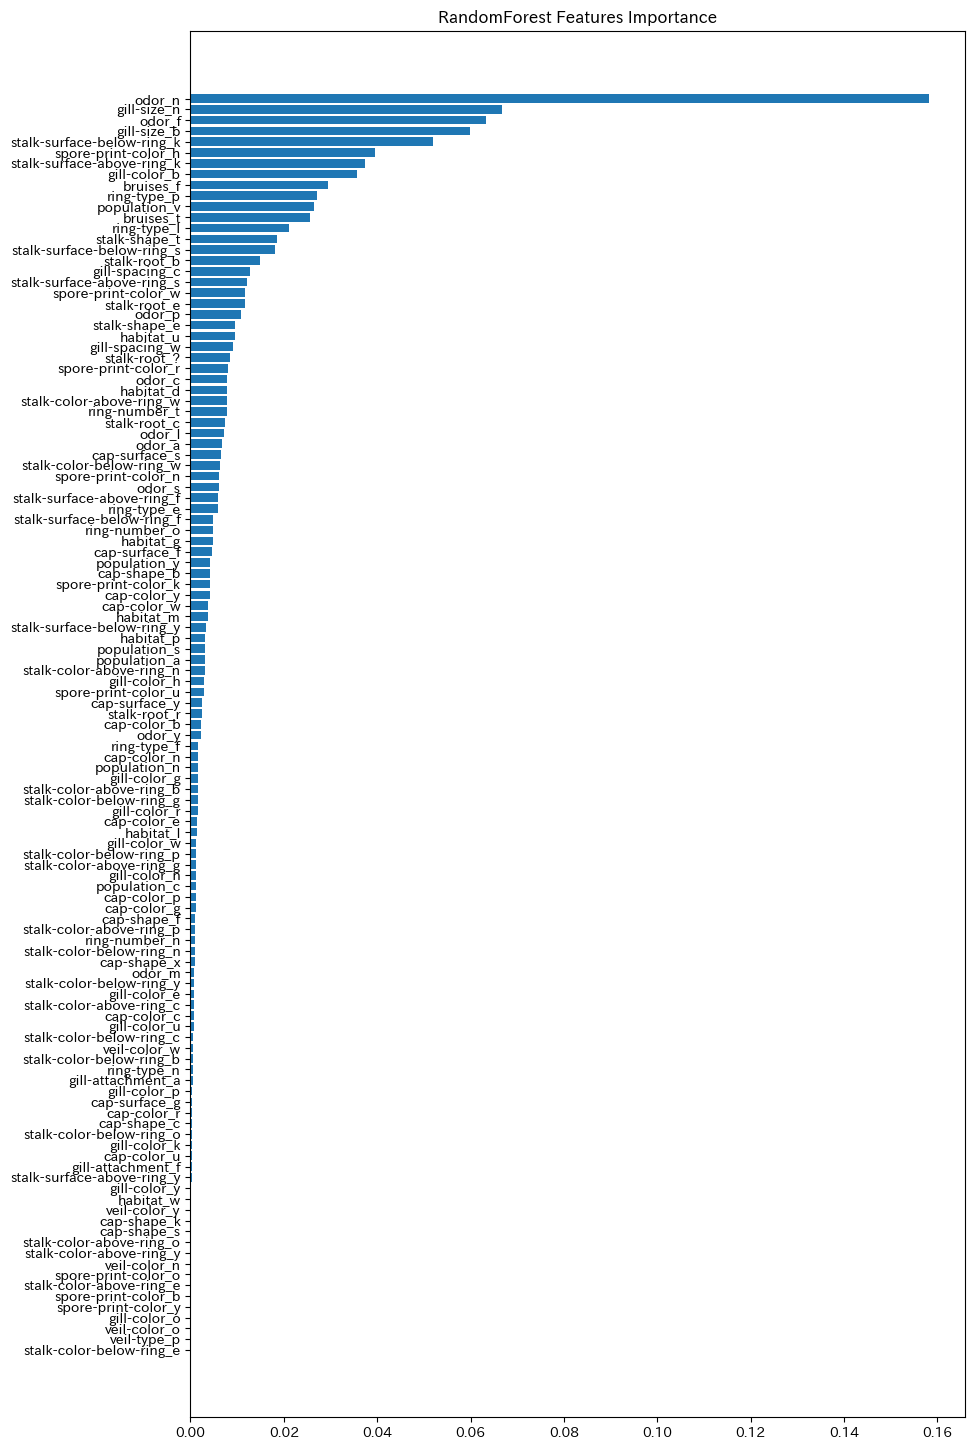

In [72]:
# Importances
importances = model_rf.feature_importances_
df_features_importance = pd.DataFrame({
    'features': X.columns,
    'importance': importances
}).sort_values('importance', ascending=True)

# Viz
plt.figure(figsize=(10, 18) )
plt.barh(df_features_importance['features'], df_features_importance['importance'])
plt.title('RandomForest Features Importance')
plt.show()

In [82]:
df_features_importance.to_csv('features_importance.csv')

# Submit

In [74]:
# Retrain
model_rf.fit(X, y)

# features
X_test = df_test.drop(['id'], axis=1)
X_test = pd.get_dummies(X_test)
X_test = X_test.reindex(columns=X.columns, fill_value=0)

In [78]:
# Pred
y_test_pred = model_rf.predict(X_test)

# Label
y_test_pred_label = pd.Series(y_test_pred).map({'0': 'e', '1': 'p'})

# DataFrame
submission = pd.DataFrame({
    'id': df_test['id'],
    'Y': y_test_pred_label
})

# Submit
submission.to_csv('submission_20250421_1.csv', header=None, index=None)